In [1]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime
from scipy.fft import fft, fftfreq,rfft2

import scipy.signal as signal
from obspy.signal import filter as obsfilt
import glob


In [2]:
WEAK = False

x_len = 5000
t_len = 6000

xs = np.arange(x_len)
dt = 1

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]  

if WEAK:
    X, T = np.meshgrid(xs, np.arange(t_len))
    XT = np.asarray([X, T]).T

    pde_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=4,
        spatiotemporal_grid=XT,
        is_uniform=True,
        K=1000,
    )
else:
    
    pde_lib = ps.PDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=4,
        spatial_grid=xs,
        include_bias=True,
        is_uniform=True,
    )
    

In [3]:
latlondepth = np.genfromtxt('south_DAS_latlondepth.txt')
relevant = latlondepth[6558:11558,3]
relevant = relevant - np.mean(relevant)
relevant = -(1/np.std(relevant))*relevant

In [4]:
h_shaped = np.tile(relevant.reshape(-1,1),t_len)
poly_library = ps.PolynomialLibrary(include_bias=True)


In [5]:
# inputs_per_library = [[1],[0,1]]
# tensor_array = [[1,1]]

In [6]:
generalized_library = ps.GeneralizedLibrary(
    [poly_library, pde_lib],
#      tensor_array=tensor_array,
#     inputs_per_library=inputs_per_library,
)

## Unfiltered

In [6]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

init = 11
final= 16

time_subsample = 10
full_dat = np.zeros((5000,(12000//time_subsample)*(final-init)))

k = 0
for i in np.arange(init,final):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    
# working_dat = full_dat/np.std(full_dat)


In [ ]:
plt.figure(figsize=(12,10))
plt.imshow(full_dat)#, vmin=-5.,vmax=5.)
plt.show()

In [15]:
scaler_val = np.std(full_dat)
scaled_dat = full_dat/scaler_val
working_dat = np.stack((scaled_dat,h_shaped), axis=-1)
# xs = np.arange(working_dat.shape[0])


### Dataset 1

#### With depth as additional PDE

In [16]:
thresh = 0.2
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, differentiation_method= ps.differentiation.SmoothedFiniteDifference())
model.fit(working_dat, t=dt,ensemble=True )

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

SINDy(differentiation_method=SmoothedFiniteDifference(),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7f4f50036550>,
      feature_names=['x0', 'x1'],
      optimizer=EnsembleOptimizer(bagging=True, n_subset=200,
                                  opt=STLSQ(alpha=0.001, max_iter=100,
                                            threshold=0.2)))

In [17]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.2
(x0)' = 0.638 x0_1 + 0.349 x0_111
(x1)' = 0.000


#### With depth as control

In [19]:
thresh = 0.2
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, differentiation_method= ps.differentiation.SmoothedFiniteDifference())
model.fit(working_dat[:,:,0].reshape(x_len,t_len,1), t=dt,ensemble=True, u=h_shaped)

SINDy(differentiation_method=SmoothedFiniteDifference(),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7f4f50036550>,
      feature_names=['x0', 'u0'],
      optimizer=EnsembleOptimizer(bagging=True, n_subset=200,
                                  opt=STLSQ(alpha=0.001, max_iter=100,
                                            threshold=0.2)))

In [20]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.2
(x0)' = 0.638 x0_1 + 0.350 x0_111 + 0.605 u0_1111 + 0.173 u0u0x0_1111


In [28]:
thresh = 0.3
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, differentiation_method= ps.differentiation.SmoothedFiniteDifference())
model.fit(working_dat[:,:,0].reshape(x_len,t_len,1), t=dt,ensemble=True, u=h_shaped)

SINDy(differentiation_method=SmoothedFiniteDifference(),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7f4e910c7f70>,
      feature_names=['x0', 'u0'],
      optimizer=EnsembleOptimizer(bagging=True, n_subset=200,
                                  opt=STLSQ(alpha=0.001, max_iter=100,
                                            threshold=0.3)))

In [29]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.3
(x0)' = 0.638 x0_1 + 0.349 x0_111


#### With tensored library

In [23]:
thresh = 0.2
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, differentiation_method= ps.differentiation.SmoothedFiniteDifference())
model.fit(working_dat[:,:,0].reshape(x_len,t_len,1), t=dt,ensemble=True, u=h_shaped)

SINDy(differentiation_method=SmoothedFiniteDifference(),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7f4e9109e190>,
      feature_names=['x0', 'u0'],
      optimizer=EnsembleOptimizer(bagging=True, n_subset=200,
                                  opt=STLSQ(alpha=0.001, max_iter=100,
                                            threshold=0.2)))

In [24]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.2
(x0)' = 0.000


In [ ]:
thresh = 1e-6
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, differentiation_method= ps.differentiation.SmoothedFiniteDifference())
model.fit(working_dat, t=dt,ensemble=True )


In [ ]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

In [ ]:
thresh = 1e-8
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True )

In [ ]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

### Dataset 2

In [40]:
time_subsample = 10
full_dat = np.zeros((5000,6000))

k = 0
for i in np.arange(21,26):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    


In [41]:
scaler_val = np.std(full_dat)
scaled_dat = full_dat/scaler_val
working_dat = np.stack((scaled_dat,h_shaped), axis=-1)

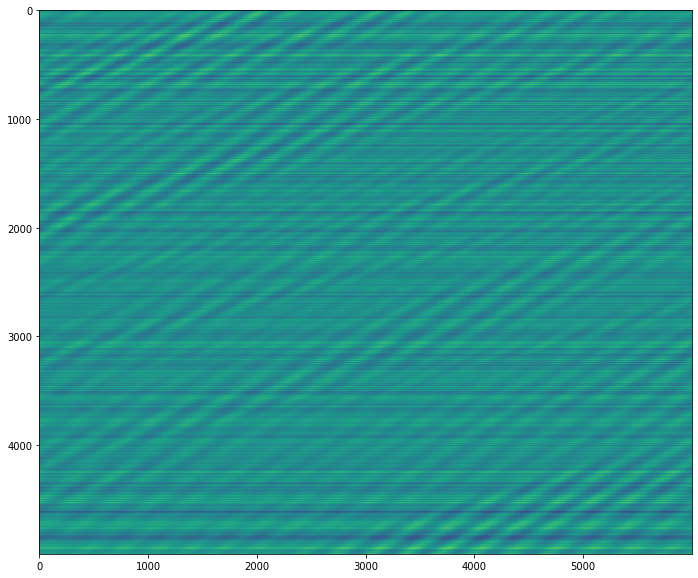

In [42]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0], vmin=-5.,vmax=5.)
plt.show()

In [43]:
thresh = 0.2
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, differentiation_method= ps.differentiation.SmoothedFiniteDifference())
model.fit(working_dat, t=dt,ensemble=True )

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity param

SINDy(differentiation_method=SmoothedFiniteDifference(),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7fe40d4ac250>,
      feature_names=['x0', 'x1'],
      optimizer=EnsembleOptimizer(bagging=True, n_subset=200,
                                  opt=STLSQ(alpha=0.001, max_iter=100,
                                            threshold=0.2)))

In [44]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.2
(x0)' = 0.666 x0_1 + 0.379 x0_111 + 1.579 x1_1111 + -2.048 x0x0x1_1111
(x1)' = 0.000


In [ ]:
thresh = 1e-6
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True )

In [ ]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

In [ ]:
thresh = 1e-8
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True )

In [ ]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

## Drift Removal Load

In [8]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy")[:,::10]
scaler_val = np.std(working_dat)
working_dat = working_dat.reshape(x_len,t_len,1)/scaler_val
# working_dat = np.stack((scaled_dat,h_shaped), axis=-1)
# xs = np.arange(working_dat.shape[0])

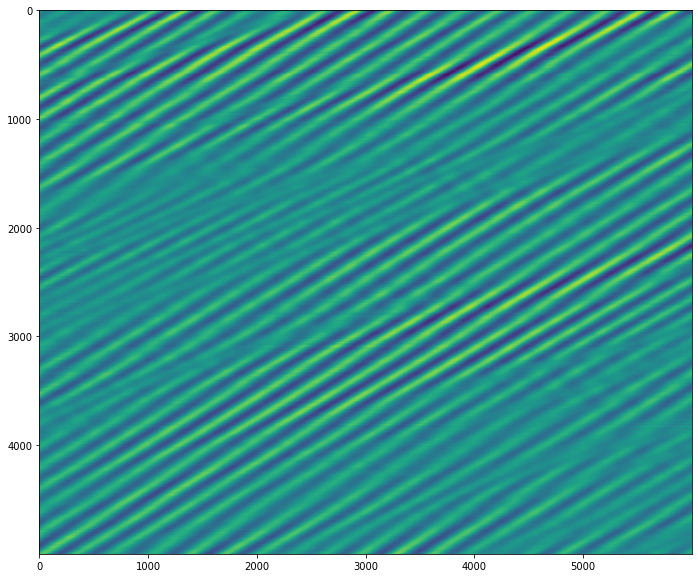

In [8]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0])
plt.show()

In [9]:
thresh = 0.2
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, differentiation_method= ps.differentiation.SmoothedFiniteDifference())
model.fit(working_dat, t=dt,ensemble=True, u=h_shaped)

SINDy(differentiation_method=SmoothedFiniteDifference(),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7fe7808686a0>,
      feature_names=['x0', 'u0'],
      optimizer=EnsembleOptimizer(bagging=True, n_subset=200,
                                  opt=STLSQ(alpha=0.001, max_iter=100,
                                            threshold=0.2)))

In [10]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.2
(x0)' = 0.643 x0_1 + 0.287 x0_111


In [29]:
np.random.seed(1923)
thresh = 0.016
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, differentiation_method= ps.differentiation.SmoothedFiniteDifference())
model.fit(working_dat, t=dt,ensemble=True, u=h_shaped)

SINDy(differentiation_method=SmoothedFiniteDifference(),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7fe7808686a0>,
      feature_names=['x0', 'u0'],
      optimizer=EnsembleOptimizer(bagging=True, n_subset=200,
                                  opt=STLSQ(alpha=0.001, max_iter=100,
                                            threshold=0.016)))

In [30]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.016
(x0)' = 0.641 x0_1 + 0.287 x0_111 + -0.010 x0u0_1


In [10]:
thresh = 0.09
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50),bagging=True,  n_models = 10,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True )

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7fa53088a250>,
      feature_names=['x0', 'x1'],
      optimizer=EnsembleOptimizer(bagging=True, n_models=10, n_subset=200,
                                  opt=STLSQ(alpha=0.001, max_iter=50,
                                            threshold=0.09)))

In [11]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.09
(x0)' = 0.235 x0_1 + 0.107 x0_111
(x1)' = 0.000


In [30]:
np.random.seed(41)
thresh = 0.015
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True )

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sp

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7fa53088a250>,
      feature_names=['x0', 'x1'],
      optimizer=EnsembleOptimizer(bagging=True, n_subset=200,
                                  opt=STLSQ(alpha=0.001, max_iter=100,
                                            threshold=0.015)))

In [31]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.015
(x0)' = 0.246 x0_1 + 0.106 x0_111 + -0.013 x0x1_1 + -0.012 x1x0_1 + -0.021 x0x0x1_1 + -0.009 x1x1x1_1
(x1)' = 0.000


### Dataset 2

In [7]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T051114Z.npy")[:,::10]
scaler_val = np.std(working_dat)
working_dat = working_dat.reshape(x_len,t_len,1)/scaler_val
# working_dat = np.stack((scaled_dat,h_shaped), axis=-1)
# xs = np.arange(working_dat.shape[0])

In [8]:
thresh = 0.1
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, differentiation_method= ps.differentiation.SmoothedFiniteDifference())
model.fit(working_dat, t=dt,ensemble=True, u=h_shaped)

SINDy(differentiation_method=SmoothedFiniteDifference(),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7fc1ba886f40>,
      feature_names=['x0', 'u0'],
      optimizer=EnsembleOptimizer(bagging=True, n_subset=200,
                                  opt=STLSQ(alpha=0.001, max_iter=100)))

In [9]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.650 x0_1 + 0.296 x0_111


In [18]:
thresh = 0.013
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, differentiation_method= ps.differentiation.SmoothedFiniteDifference())
model.fit(working_dat, t=dt,ensemble=True, u=h_shaped)

SINDy(differentiation_method=SmoothedFiniteDifference(),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7fc1ba886f40>,
      feature_names=['x0', 'u0'],
      optimizer=EnsembleOptimizer(bagging=True, n_subset=200,
                                  opt=STLSQ(alpha=0.001, max_iter=100,
                                            threshold=0.013)))

In [19]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.013
(x0)' = 0.650 x0_1 + 0.296 x0_111 + 0.021 u0u0x0_1 + 0.058 x0x0x0_1111


In [26]:
thresh = 0.009
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, differentiation_method= ps.differentiation.SmoothedFiniteDifference())
model.fit(working_dat, t=dt,ensemble=True, u=h_shaped)

SINDy(differentiation_method=SmoothedFiniteDifference(),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7fc1ba886f40>,
      feature_names=['x0', 'u0'],
      optimizer=EnsembleOptimizer(bagging=True, n_subset=200,
                                  opt=STLSQ(alpha=0.001, max_iter=100,
                                            threshold=0.009)))

In [27]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.009
(x0)' = 0.649 x0_1 + 0.296 x0_111 + -0.012 x0u0_1 + -0.004 x0x0u0_11 + 0.058 x0x0x0_1111 + -0.001 x0x0u0_1111


In [28]:
thresh = 0.002
optimizer = ps.EnsembleOptimizer( opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100),bagging=True,  n_models = 20,n_subset =200) #int(t_len*0.01))#opt=ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, differentiation_method= ps.differentiation.SmoothedFiniteDifference())
model.fit(working_dat, t=dt,ensemble=True, u=h_shaped)

SINDy(differentiation_method=SmoothedFiniteDifference(),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7fc1ba886f40>,
      feature_names=['x0', 'u0'],
      optimizer=EnsembleOptimizer(bagging=True, n_subset=200,
                                  opt=STLSQ(alpha=0.001, max_iter=100,
                                            threshold=0.002)))

In [29]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.002
(x0)' = 0.719 x0_1 + -0.022 u0_1 + -0.004 x0_11 + -0.676 u0_11 + 0.354 x0_111 + -0.001 x0_1111 + -0.213 u0_1111 + 0.001 x0x0_1 + -0.044 x0u0_1 + -0.011 u0x0_1 + -0.046 u0u0_1 + 0.019 x0x0x0_1 + -0.001 x0x0u0_1 + 0.026 u0u0x0_1 + -0.001 u0u0u0_1 + -0.003 x0u0_11 + -0.004 u0u0_11 + 2.263 x0x0x0_11 + 0.330 x0x0u0_11 + 0.537 u0u0x0_11 + 0.001 x0x0_111 + -0.027 x0u0_111 + -0.005 u0x0_111 + -0.043 u0u0_111 + -0.329 x0x0x0_111 + 0.043 u0u0u0_111 + -0.001 u0u0_1111 + 0.642 x0x0x0_1111 + 0.091 x0x0u0_1111 + 0.181 u0u0x0_1111 + -0.007 u0u0u0_1111


In [84]:
thresh = 0.01
optimizer = ps.EnsembleOptimizer(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt )

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.01))

In [85]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.145 x0_1 + 0.068 x0_111


In [90]:
thresh = 5e-3
optimizer = ps.EnsembleOptimizer(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt )


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.005))

In [91]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.005
(x0)' = 0.145 x0_1 + 0.068 x0_111


In [88]:
thresh = 0.002
optimizer = ps.EnsembleOptimizer(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt )

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.002))

In [89]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.002
(x0)' = 0.157 x0_1 + 0.075 x0_111 + -0.008 x0x0x0_1 + -0.005 x0x0x0_111


## Multifilt

In [93]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/rad_4_smoothed_decimated_normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T051114Z.npy")
scaler_val = np.std(working_dat)
scaled_dat = working_dat/scaler_val
working_dat = np.stack((scaled_dat,h_shaped), axis=-1)


### Dataset 1

In [96]:
thresh = 5e-1
optimizer = ps.EnsembleOptimizer(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt )


SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.5))

In [97]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.5
(x0)' = 0.568 x0_1 + 3.874 x0_111


In [98]:
thresh = 1e-1
optimizer = ps.EnsembleOptimizer(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt )

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=100))

In [99]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.568 x0_1 + 3.828 x0_111 + 0.033 x0x0x0_111


In [100]:
thresh = 5e-2
optimizer = ps.EnsembleOptimizer(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt )

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.05))

In [101]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.05
(x0)' = 0.568 x0_1 + 3.828 x0_111 + 0.033 x0x0x0_111


In [110]:
thresh = 3e-2
optimizer = ps.EnsembleOptimizer(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt )

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.03))

In [111]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.03
(x0)' = 0.568 x0_1 + 3.828 x0_111 + -0.008 x0_1111 + 0.033 x0x0x0_111


### Dataset 2

In [116]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/rad_4_smoothed_decimated_normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T231114Z.npy")
scaler_val = np.std(working_dat)
scaled_dat = working_dat/scaler_val
working_dat = np.stack((scaled_dat,h_shaped), axis=-1)


In [117]:
thresh = 5e-1
optimizer = ps.EnsembleOptimizer(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt )

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.5))

In [118]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.5
(x0)' = 0.514 x0_1 + 3.516 x0_111


In [119]:
thresh = 0.1
optimizer = ps.EnsembleOptimizer(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt )

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=100))

In [120]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.514 x0_1 + 3.516 x0_111


In [123]:
thresh = 5e-2
optimizer = ps.EnsembleOptimizer(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt )


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.05))

In [124]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.05
(x0)' = 0.514 x0_1 + 3.499 x0_111 + 0.013 x0x0x0_111


In [121]:
thresh = 3e-2
optimizer = ps.EnsembleOptimizer(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt )


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.03))

In [122]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.03
(x0)' = 0.514 x0_1 + 3.499 x0_111 + 0.013 x0x0x0_111 + -0.002 x0x0_1111


In [47]:
thresh = 1e-2
optimizer = ps.EnsembleOptimizer(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(working_dat, t=dt )

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.01))

In [48]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.572 x0_1 + 3.842 x0_111 + 0.002 x0_1111 + 0.014 x0x0x0_111 + -0.002 x0x0x0_1111
